# This Jupyter book is based on chapter 1 & 2 of Hans-On Machine Learning with Scikit-Learn, Keras & TensorFlow

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
%run ../../base-notebook.ipynb

zsh:1: no matches found: ml_*.py
--2023-05-16 11:53:06--  https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/contents.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444 [text/plain]
Saving to: ‘contents.txt’

contents.txt        100%[===================>]     444  --.-KB/s    in 0s      

2023-05-16 11:53:07 (52.9 MB/s) - ‘contents.txt’ saved [444/444]

--2023-05-16 11:53:07--  https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_callback.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response.

In [3]:
import sys

sys.path.append("../../ext")

import ext.ml_io as mli
import ext.ml_util as mlu

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download and extract the housing data

In [11]:
source = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz"
destination = "datasets/housing/housing.tgz"

mli.download_file(source=source, destination=destination)
mli.extract_tgz(file=destination)

# Load and view the housing data

In [2]:
housing = pd.read_csv("datasets/housing/housing.csv")

In [3]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


# Display some details about the dataset

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Interesting notes:

One of the columns has empty fields, total_bedrooms
One column is not numeric, ocean_proximity

# Display possible values for ocean_proximity

In [5]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

# Show summary of the housing data

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## This table shows:
count: Number of records
mean: Sum of all values devided by the number of values
std: Standard deviation ( σ ), tells us how disperse the data is in relation to the mean, small deviation means all data is centered around the mean, high deviation means that the data is wide spead around the mean.
min: Min value
25%: 25% of the records fall below the shown value
50%: 50% of the records fall below the shown value
75%: 75% of the records fall below the shown value
max: Max value (and coincidentely 100% of the records fall below the shown value)


# Plot a histogram of all the values to see the distribution of the values

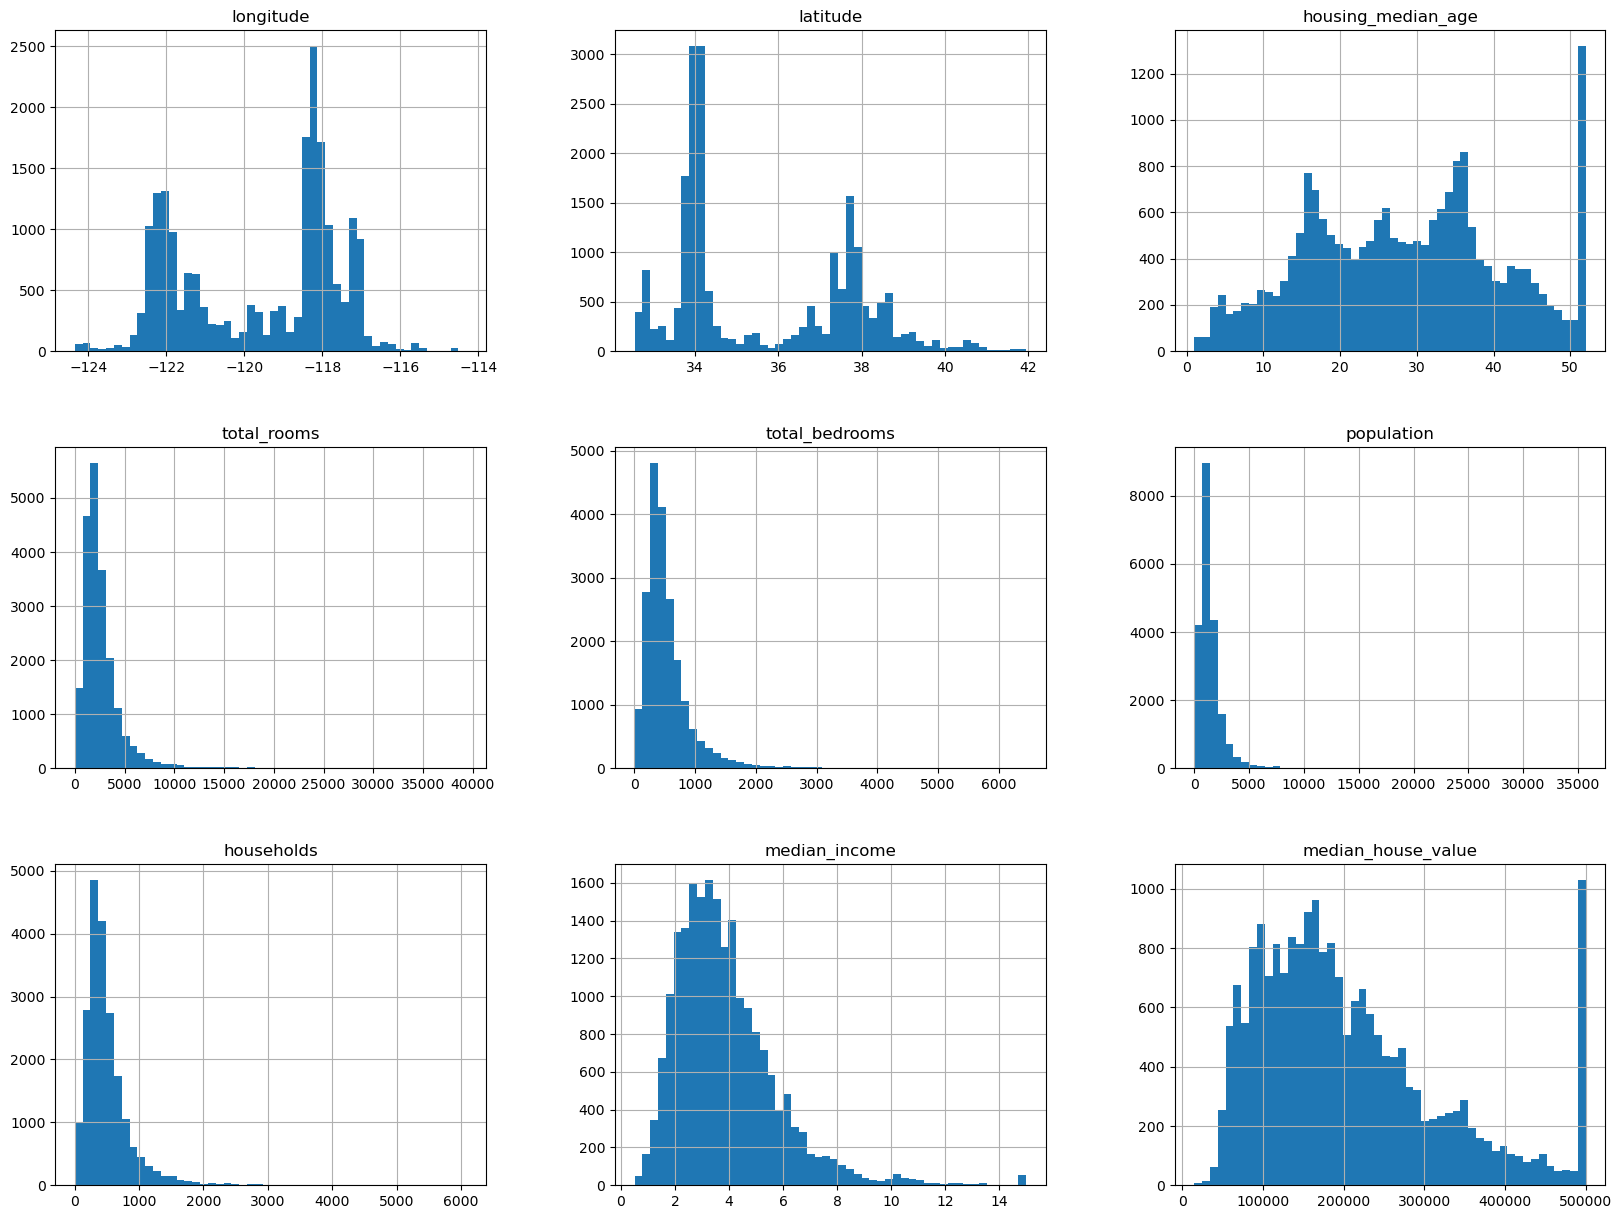

In [7]:
%matplotlib inline
housing.hist(bins=50, figsize=(20, 15))
plt.show()


In [8]:
train_set, test_set = mlu.split_train_test_data(housing)

# Create a new column categorizing the mdeian income in 5 different groups

<Axes: >

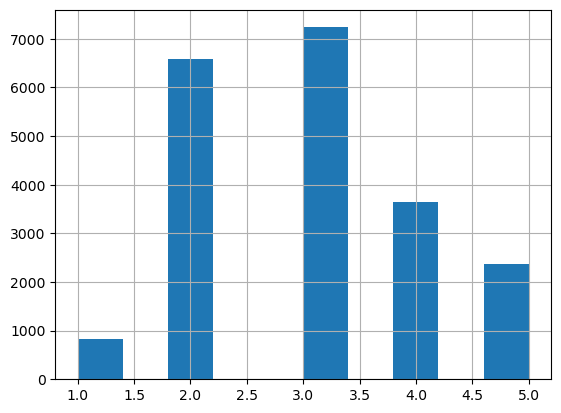

In [15]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

# Split data based on the new income_cat column

This way the test data contains a similar representation as the training data for the median_income

In [24]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=52)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [27]:
value_counts = strat_test_set["income_cat"].value_counts()
value_counts, value_counts / len(strat_test_set)

(income_cat
 3    1447
 2    1316
 4     728
 5     472
 1     165
 Name: count, dtype: int64,
 income_cat
 3    0.350533
 2    0.318798
 4    0.176357
 5    0.114341
 1    0.039971
 Name: count, dtype: float64)

In [28]:
value_counts = strat_train_set["income_cat"].value_counts()
value_counts, value_counts / len(strat_train_set)

(income_cat
 3    5789
 2    5265
 4    2911
 5    1890
 1     657
 Name: count, dtype: int64,
 income_cat
 3    0.350594
 2    0.318859
 4    0.176296
 5    0.114462
 1    0.039789
 Name: count, dtype: float64)

# Remove the income_cat columns

In [29]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Copy the data so we can experiment with some visualizations without changing the original data-set

<Axes: xlabel='longitude', ylabel='latitude'>

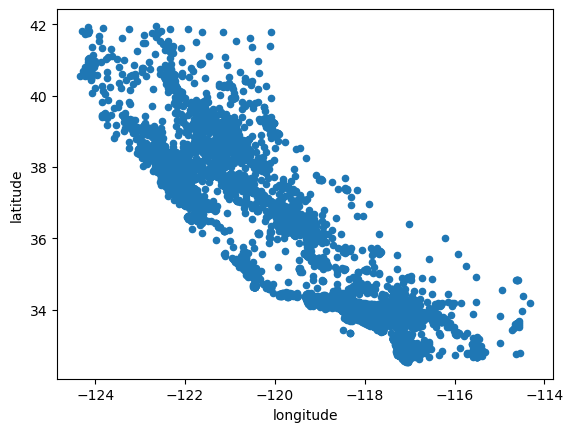

In [30]:
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")

# Plot a more detailed scatter plot, housing prices are shown using color, circle size indicate population size.

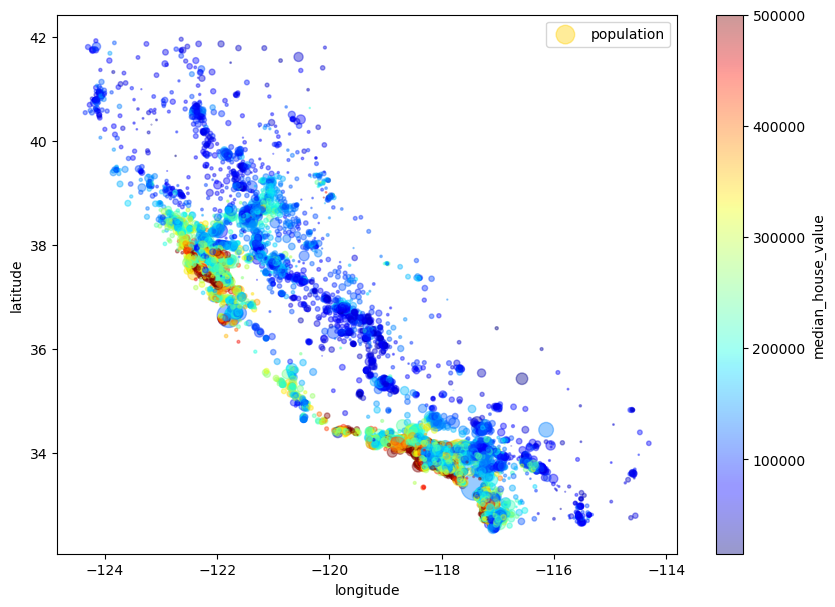

In [32]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population", figsize=(10, 7), c="median_house_value",
             cmap=plt.get_cmap('jet'),
             colorbar=True)
plt.legend()

# Look for correlations between the median price of the house and the other attributes

In [35]:
housing_num_only = housing.drop("ocean_proximity", axis=1)

corr_matrix = housing_num_only.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688001
total_rooms           0.131945
housing_median_age    0.102734
households            0.063677
total_bedrooms        0.046401
population           -0.025101
longitude            -0.051031
latitude             -0.138629
Name: median_house_value, dtype: float64

### The correlation coefficient ranges from -1 to 1.

Close to 1 means that there is a strong positive correlation, house value tends to go up when median_income goes up.
Close to -1 means that there is a strong negative correlation, house value tends to go down when you go north.
Close to 0 means that there is no linear correlation.

Note: It is a linear correlation, so it will miss out on non-linear correlations.

# Plot scatter plots vor various columns against each other.

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

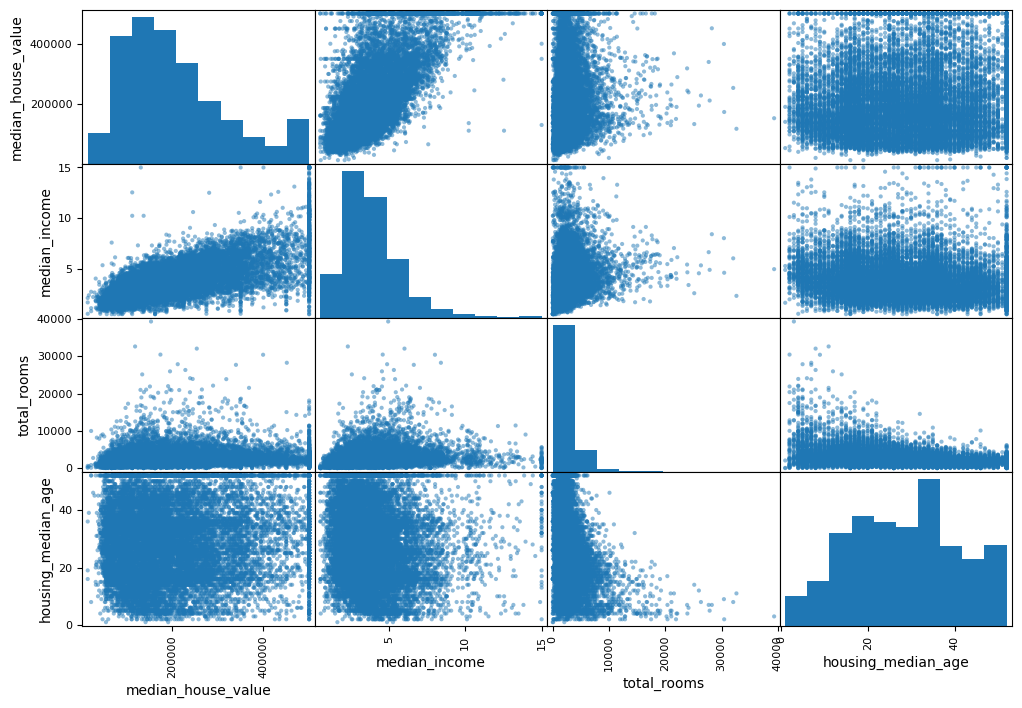

In [36]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
pd.plotting.scatter_matrix(housing[attributes], figsize=(12, 8))

# Plot a scatter plot between median income and median house value since they have a high correlation

<Axes: xlabel='median_income', ylabel='median_house_value'>

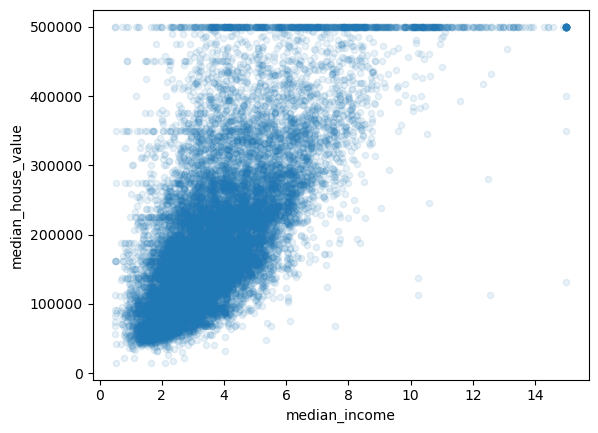

In [37]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

The correlation is very strong, you can clearly see the upwards trend, and the points are not too dispersed. The price cap is also clearly visible with a thick line of dots.

Do notice that there seems to be more then one, arround the 350.000 and 240.000 there are also lines forming. We might consider to remove these values to prevent the algorithm from learning to reproduce these data quirks.

# Add some more columns for rooms and population

The number of rooms and the population size is the total for each district, so it might be a good idea to divide these among the households.

In [40]:
housing_num_only["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing_num_only["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing_num_only["population_per_household"] = housing["population"] / housing["households"]

In [41]:
corr_matrix = housing_num_only.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688001
rooms_per_household         0.151398
total_rooms                 0.131945
housing_median_age          0.102734
households                  0.063677
total_bedrooms              0.046401
population_per_household   -0.021648
population                 -0.025101
longitude                  -0.051031
latitude                   -0.138629
bedrooms_per_room          -0.257667
Name: median_house_value, dtype: float64

Now we can see that the bedrooms_per_room are more correlated to the median house value then the original total_bedrooms. Same is for rooms_per_household and population_per_household.

# Cleanup the data sets

In [43]:
# First create a copy without the median_house_value as our data without labels.
housing = strat_train_set.drop("median_house_value", axis=1)

# Create a copy of the median_house_value as our labels.
housing_labels = strat_train_set["median_house_value"].copy()

## Fill in the blank values by using an SimpleImputer, since this can only work on numerical columns we need to remove the ocean_proximity first.

In [47]:
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)

In [48]:
imputer.fit(housing_num)
imputer.statistics_

array([-118.48   ,   34.25   ,   29.     , 2127.     ,  435.     ,
       1166.     ,  409.     ,    3.54035])

### The values above represent the median values of the various columns, compare this to the medean values calculated through pandas.

In [49]:
housing_num.median().values

array([-118.48   ,   34.25   ,   29.     , 2127.     ,  435.     ,
       1166.     ,  409.     ,    3.54035])

In [50]:
# Apply the imputer on the housing data.
X = imputer.transform(housing_num)

In [53]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [59]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 20220 to 14965
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


As we can see, the total_bedrooms now has the same amount of non-null values as the other columns.

# Handling Test and Categorical attributes

Encode the ocean_primixty through indexes

In [70]:
# Note the double [[]], this is to make sure the shape becomes (16512, 1) column instead of (16512) array.
housing_cat = housing[["ocean_proximity"]]
housing_cat[:10]

,ocean_proximity
20220,NEAR OCEAN
10735,<1H OCEAN
12430,INLAND
12914,INLAND
7169,<1H OCEAN
15413,<1H OCEAN
214,NEAR BAY
3110,INLAND
15003,NEAR OCEAN
15308,NEAR OCEAN


In [71]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[4.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [3.],
       [1.],
       [4.],
       [4.]])

The values are now encoded but you will notice that it is a single column where each value has their own index (1, 2, 3, 4, ..) for each coresponding values. Machine leanring algorithms don't really like this since it suggests that the value 4 is further away from value 1, while in this case this is not true, here the index just represents a single fact not related to the other values.

In [75]:
# Display all values for ocean_proximity
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

# Apply One-Hot-Encoding to ocean_proximity

In [77]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

This results in a sparse matrix, this is very convenient memory wise. For actual one-hot encoding your would get 16512 * num_cat amount of cells which is a lot in large datasets. To still get it completely we can use the .toarray() method.

In [78]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [79]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

# Custom Transformers

In [86]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [92]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [93]:
housing_extra_attribs[:1]

array([[-119.27, 34.28, 52.0, 2239.0, 420.0, 941.0, 397.0, 4.125,
        'NEAR OCEAN', 5.6397984886649875, 2.370277078085642]],
      dtype=object)

As we can see we now have 2 more columns, 5.639.. and 2.370.., the third extra column is not there since we specified not to add bedrooms per room.

# Feature Scaling

For example using MinMaxScaler, this will transform the entire value range to a range of 0 to 1. This does have a downside, if the data has outliers then the results might not be as expected. Suppose the general values have a mean of 100, then MinMaxScaling would the ncrush all the other values from 0-15 down to 0 - 0.15.

To solve this you can also use the StandardScaler, this will first subtract the mean value, and then it dividesby the standard deviation so that the resulting distribution has unit variance.

For more details:

https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#standardscaler
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#minmaxscaler

# Transformation Pipelines

In [185]:
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
20220,-119.27,34.28,52.0,2239.0,420.0,941.0,397.0,4.1250
10735,-117.89,33.60,36.0,1496.0,247.0,441.0,203.0,7.8164
12430,-116.26,33.65,3.0,7437.0,1222.0,574.0,302.0,10.2948
12914,-121.32,38.61,22.0,3902.0,845.0,1870.0,763.0,2.7740
7169,-118.18,34.06,33.0,278.0,71.0,266.0,56.0,0.8941
...,...,...,...,...,...,...,...,...
9422,-122.66,37.93,42.0,1505.0,324.0,553.0,277.0,4.1792
16456,-121.27,38.12,44.0,2356.0,482.0,1043.0,443.0,2.4949
13195,-117.71,34.07,24.0,1948.0,362.0,1286.0,364.0,3.6000
12685,-121.40,38.53,38.0,152.0,30.0,65.0,35.0,0.9274


In [186]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # Replace missing values with median values
    ('attribs_adder', CombinedAttributesAdder()),  # Add additional columns rooms_per_household, population_per_household, bedrooms_per_room
    ('std_scaler', StandardScaler())               # Scale values
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [187]:
housing_num_tr

array([[ 0.1454227 , -0.62910633,  1.85968147, ...,  0.08374667,
        -0.06288682, -0.41739347],
       [ 0.83417059, -0.94864981,  0.58508334, ...,  0.76580616,
        -0.07996451, -0.77536265],
       [ 1.64769164, -0.92515396, -2.0437753 , ...,  7.5705384 ,
        -0.10341953, -0.78799823],
       ...,
       [ 0.92400727, -0.72778888, -0.37086525, ..., -0.02988004,
         0.03746558, -0.44529804],
       [-0.91764469,  1.36804037,  0.74440811, ..., -0.42767831,
        -0.10717572, -0.26156102],
       [ 1.28335399, -1.35277831, -0.84883955, ...,  0.04827078,
         0.01239736, -0.49231599]])

In [258]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),   # Apply all transformations mentioned in the num_pipeline on specified columns
    ("cat", OneHotEncoder(), cat_attribs) # One-hot encode the ocean_proximity column
])

housing_prepared = full_pipeline.fit_transform(housing)

In [189]:
housing_prepared

array([[ 0.1454227 , -0.62910633,  1.85968147, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.83417059, -0.94864981,  0.58508334, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.64769164, -0.92515396, -2.0437753 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.92400727, -0.72778888, -0.37086525, ...,  0.        ,
         0.        ,  0.        ],
       [-0.91764469,  1.36804037,  0.74440811, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.28335399, -1.35277831, -0.84883955, ...,  0.        ,
         0.        ,  0.        ]])

In [190]:
housing_prepared.shape

(16512, 16)

# Training an evaluating on the Training Set

Create a linear regression model and try to train it with the given training data and labels

In [191]:
# Train the model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [197]:
# Get some sample data
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

In [198]:
some_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
20220,-119.27,34.28,52.0,2239.0,420.0,941.0,397.0,4.1250,NEAR OCEAN
10735,-117.89,33.60,36.0,1496.0,247.0,441.0,203.0,7.8164,<1H OCEAN
12430,-116.26,33.65,3.0,7437.0,1222.0,574.0,302.0,10.2948,INLAND
12914,-121.32,38.61,22.0,3902.0,845.0,1870.0,763.0,2.7740,INLAND
7169,-118.18,34.06,33.0,278.0,71.0,266.0,56.0,0.8941,<1H OCEAN


In [199]:
# Display the labels we will be expecting from the prediction
some_labels

20220    349000.0
10735    500001.0
12430    382400.0
12914    190200.0
7169      98200.0
Name: median_house_value, dtype: float64

In [200]:
# Preprocess the sampling data
some_data_prepared = full_pipeline.transform(some_data)

In [201]:
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [287485.35940505 385863.81889093 429993.87630272 117570.00199918
 102595.02735676]


In [204]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68560.86663070651

Not a great result, on average the model is off by $68.560 in it's prediction. Normally you would:

1) Train with more data
2) Create a more complex model
3) Add better / more features
4) Reduce constraints on the model

In this case let's try a different model.

# Create a new model using DecisionTreeRegressor

In [206]:
# Create the model and train it.
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [208]:
# Try some predictions and check the error
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

It is highly unlikely that this model performs a 100%, so there must be an issue with this model

## Better evaluation using cross-validation

In [210]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_score = np.sqrt(-scores)

In [211]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

In [213]:
display_scores(tree_rmse_score)

Scores:  [68425.68455586 72660.12547597 68221.03109559 68250.30667889
 71193.6095397  70362.54405911 70190.283613   71532.00484442
 72498.84035612 68988.95526676]
Mean:  70232.33854854244
Standard deviation:  1626.2498251401341


This is still not very good, we are on average off by $70.323.

## Compare score above (of the DecisionTreeRegressor) with that of the LinearRegression

In [215]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_score = np.sqrt(-lin_scores)
display_scores(lin_rmse_score)

Scores:  [69738.57862829 69466.01236928 65836.51818786 69925.58510192
 68582.93127608 72895.34490849 66384.99435872 66902.96301829
 69335.94390469 68959.21458543]
Mean:  68802.80863390432
Standard deviation:  1947.7203384158831


#### Seems our linear model actually performed worse (which does not happen in the book, we lucky?

In [217]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
for_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
for_rmse_scores = np.sqrt(-for_scores)
display_scores(for_rmse_scores)

Scores:  [49212.0976395  51789.43072892 47708.54638283 51383.5857729
 51324.02122495 49058.61956858 48476.59564849 49281.40438988
 50972.59593598 51633.28359205]
Mean:  50084.01808840748
Standard deviation:  1414.470193346338


The RandomForestRegressor performs much better with a mean of $50.084 and a standard deviation of 1414 it performs better then all previous models.

## Grid Search to optimize hyperparameters.

In [219]:
param_grid = [
    {
        'n_estimators': [3, 10, 30],
        'max_features': [2, 4, 6, 8]
     },
    {
        'bootstrap': [False],
        'n_estimators': [3, 10],
        'max_features': [2, 3, 4]
    }
]

First round evaluate 3 * 4 combinations, second round try 2 * 3 with bootstrap set to false.

In [221]:
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg,
                           param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True
                           )
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

Check the best model parameters from the grid search

In [222]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [223]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [225]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64512.12211280687 {'max_features': 2, 'n_estimators': 3}
56019.78801093027 {'max_features': 2, 'n_estimators': 10}
52051.21268779006 {'max_features': 2, 'n_estimators': 30}
60619.661473191634 {'max_features': 4, 'n_estimators': 3}
52819.48652774409 {'max_features': 4, 'n_estimators': 10}
50455.21455591618 {'max_features': 4, 'n_estimators': 30}
59691.779219872966 {'max_features': 6, 'n_estimators': 3}
52492.24522992694 {'max_features': 6, 'n_estimators': 10}
49973.06927368573 {'max_features': 6, 'n_estimators': 30}
59320.286814977066 {'max_features': 8, 'n_estimators': 3}
52533.109249891146 {'max_features': 8, 'n_estimators': 10}
50101.33093738967 {'max_features': 8, 'n_estimators': 30}
62481.08871748471 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54371.152928523705 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60153.33700174787 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52630.90432116535 {'bootstrap': False, 'max_features': 3, 'n_estimators

Here you can see all the different models that have been tested, the one with the lowest score performs the best.

## analyze the best models and their errors

In [226]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [227]:
feature_importances

array([7.42014806e-02, 7.22103952e-02, 4.46658646e-02, 1.88682068e-02,
       1.66275457e-02, 1.85483623e-02, 1.64308606e-02, 3.50524244e-01,
       5.21414954e-02, 1.01571987e-01, 6.61745514e-02, 1.15550236e-02,
       1.49334289e-01, 1.60252134e-04, 2.31497726e-03, 4.67046432e-03])

Each value corresponds with a feature of the dataset, each value represents the importance of that perticular field.

In [228]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.350524243810565, 'median_income'),
 (0.14933428913870317, 'INLAND'),
 (0.1015719872385585, 'pop_per_hhold'),
 (0.07420148058662095, 'longitude'),
 (0.07221039518908626, 'latitude'),
 (0.06617455137716474, 'bedrooms_per_room'),
 (0.05214149542433774, 'rooms_per_hhold'),
 (0.04466586458127453, 'housing_median_age'),
 (0.018868206780881355, 'total_rooms'),
 (0.01854836229957895, 'population'),
 (0.016627545689293626, 'total_bedrooms'),
 (0.016430860564594772, 'households'),
 (0.011555023608192237, '<1H OCEAN'),
 (0.004670464321152871, 'NEAR OCEAN'),
 (0.002314977255504896, 'NEAR BAY'),
 (0.00016025213449035318, 'ISLAND')]

Here we can see which features are important and which are not, the lower the score, the less interesting the specific feature is.

## Evaluate the system on the test set

In [229]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)

In [231]:
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_mse, final_rmse

(2296003256.8923044, 47916.628187846276)

In [236]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([45837.00361484, 49909.67454711])

So in the end, our best model had a RMSE of 49973 when using the training data, when using the test data it was even a bit better with a RMSE of 47916. When we just evaluate using 95 percentile we get 49909

https://machinelearningmastery.com/confidence-intervals-for-machine-learning/#

## Try Support Vector Machine

In [238]:
svr_reg = SVR()
svr_reg.fit(housing_prepared, housing_labels)

SVR()

In [239]:
svr_scores = cross_val_score(svr_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-for_scores)
display_scores(for_rmse_scores)

Scores:  [49212.0976395  51789.43072892 47708.54638283 51383.5857729
 51324.02122495 49058.61956858 48476.59564849 49281.40438988
 50972.59593598 51633.28359205]
Mean:  50084.01808840748
Standard deviation:  1414.470193346338


## Try RandomizedSearchCV

In [251]:
from scipy.stats import expon, reciprocal

param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svr_reg = SVR()
random_search = RandomizedSearchCV(svr_reg,
                           param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True
                           )
random_search.fit(housing_prepared, housing_labels)

KeyboardInterrupt: 

In [244]:
random_search.best_params_

{'n_estimators': 30, 'max_features': 6}

In [245]:
random_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [246]:
cvres = random_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres["params"]):
    print(np.sqrt(-mean_score), params)

52616.53274481894 {'n_estimators': 10, 'max_features': 4}
59007.608407788706 {'n_estimators': 3, 'max_features': 4, 'bootstrap': False}
50020.28862501056 {'n_estimators': 30, 'max_features': 6}
50438.13468014756 {'n_estimators': 30, 'max_features': 4}
57919.070814192986 {'n_estimators': 3, 'max_features': 8}
52228.29667712635 {'n_estimators': 10, 'max_features': 6}
51774.41727538882 {'n_estimators': 10, 'max_features': 4, 'bootstrap': False}
52247.41630617706 {'n_estimators': 10, 'max_features': 8}
63869.046577652414 {'n_estimators': 3, 'max_features': 2}
54121.16111941374 {'n_estimators': 10, 'max_features': 2, 'bootstrap': False}


## Adjust pipeline to filter out features that are not interesting

In [252]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        """
        :param feature_importances: the features
        :param k: top k features to use
        """
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [254]:
k = 5

top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12])

Check which fields were selected

In [256]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

Let's double check that these are indeed the top k features:

In [257]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.350524243810565, 'median_income'),
 (0.14933428913870317, 'INLAND'),
 (0.1015719872385585, 'pop_per_hhold'),
 (0.07420148058662095, 'longitude'),
 (0.07221039518908626, 'latitude')]

Create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection

In [259]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [260]:
housing_prepared_top_k_features[0:3]

array([[ 0.1454227 , -0.62910633,  0.12979893, -0.06288682,  0.        ],
       [ 0.83417059, -0.94864981,  2.05930386, -0.07996451,  0.        ],
       [ 1.64769164, -0.92515396,  3.35477035, -0.10341953,  1.        ]])

Double check that these are indeed the top k features:

In [261]:
housing_prepared[0:3, top_k_feature_indices]

array([[ 0.1454227 , -0.62910633,  0.12979893, -0.06288682,  0.        ],
       [ 0.83417059, -0.94864981,  2.05930386, -0.07996451,  0.        ],
       [ 1.64769164, -0.92515396,  3.35477035, -0.10341953,  1.        ]])